## IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
from pandas.plotting import scatter_matrix
import os
import csv
from zipfile import ZipFile
from datetime import datetime
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV, PassiveAggressiveClassifier
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid, NeighborhoodComponentsAnalysis
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from itertools import combinations_with_replacement
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier

## IMPORT DATASETS

In [2]:
Test=pd.read_excel('Test.xlsx',sheet_name='Sheet1')
Train=pd.read_excel('Train.xlsx',sheet_name='Sheet1')

## EXPLORE

### DATA EXPLORATION

In [3]:
Train.shape

(22400, 15)

In [4]:
Test.shape

(10100, 14)

In [5]:
Train.columns

Index(['CITIZEN_ID', 'Name', 'Birthday', 'Native Continent', 'Marital Status',
       'Lives with', 'Base Area', 'Education Level', 'Years of Education',
       'Employment Sector', 'Role', 'Working Hours per week', 'Money Received',
       'Ticket Price', 'Income'],
      dtype='object')

In [6]:
Test.columns

Index(['CITIZEN_ID', 'Name', 'Birthday', 'Native Continent', 'Marital Status',
       'Lives with', 'Base Area', 'Education Level', 'Years of Education',
       'Employment Sector', 'Role', 'Working Hours per week', 'Money Received',
       'Ticket Price'],
      dtype='object')

In [7]:
Train.describe()

,CITIZEN_ID,Years of Education,Working Hours per week,Money Received,Ticket Price,Income
count,22400.000000,22400.000000,22400.000000,22400.000000,22400.000000,22400.000000
mean,23685.500000,13.173884,40.483795,1324.915357,109.145313,0.237098
std,6466.467351,2.512451,12.370921,9227.771813,500.208904,0.425313
min,12486.000000,2.000000,1.000000,0.000000,0.000000,0.000000
25%,18085.750000,12.000000,40.000000,0.000000,0.000000,0.000000
50%,23685.500000,13.000000,40.000000,0.000000,0.000000,0.000000
75%,29285.250000,15.000000,45.000000,0.000000,0.000000,0.000000
max,34885.000000,21.000000,99.000000,122999.000000,5358.000000,1.000000


## Missing values analysis

Number of missing values by variable

In [8]:
Train.replace({'?': None},inplace =True)
Train_null = Train.isnull().sum()
print('Null values of Train:', Train_null)
Test.replace({'?': None},inplace =True)
Test_null = Test.isnull().sum()
print('Null values of Test:', Test_null)

Null values of Train: CITIZEN_ID                   0
Name                         0
Birthday                     0
Native Continent             0
Marital Status               0
Lives with                   0
Base Area                  395
Education Level              0
Years of Education           0
Employment Sector         1264
Role                      1271
Working Hours per week       0
Money Received               0
Ticket Price                 0
Income                       0
dtype: int64
Null values of Test: CITIZEN_ID                  0
Name                        0
Birthday                    0
Native Continent            0
Marital Status              0
Lives with                  0
Base Area                 187
Education Level             0
Years of Education          0
Employment Sector         570
Role                      570
Working Hours per week      0
Money Received              0
Ticket Price                0
dtype: int64


In [9]:
# Save the Citizen ID for furthur use
train_citizen_id = Train['CITIZEN_ID']
test_citizen_id = Test['CITIZEN_ID']
del Train['CITIZEN_ID']
del Test['CITIZEN_ID']

## Data Normalization

The first phase is to find out the gender of citizens

In [10]:
## Variable 'Sex'
# Train
Train['Sex'] = Train['Name'].str.split(' ').str[0].str.replace(' ', '').str.replace('.', '').apply(lambda x: 1 if x == 'Mr' else 0)
del Train['Name']
# Test
Test['Sex'] = Test['Name'].str.split(' ').str[0].str.replace(' ', '').str.replace('.', '').apply(lambda x: 1 if x == 'Mr' else 0)
del Test['Name']

Next, is to calculate age of citizens by thir birthday

In [11]:
# Train
Train['Age'] =(Train['Birthday'].astype(str).str[-4:].astype(int).sub(2048) * -1).astype(int)
del Train['Birthday']
# Test
Test['Age'] = (Test['Birthday'].astype(str).str[-4:].astype(int).sub(2048) * -1).astype(int)
del Test['Birthday']

Next phase is to convert categorical data into seperated boolean columns

In [12]:
# Define a function to convert given fields into boolan column based on grouping unique values and drop former column
def set_values_as_column(field, df1 = Train, df2=Test):
    for item in df1[field].value_counts().index:
        df1[item] = df1[field].apply(lambda x: 1 if x == item else 0)
    del df1[field]
    
    for item in df2[field].value_counts().index:
        df2[item] = df2[field].apply(lambda x: 1 if x == item else 0)
    del df2[field]

In [13]:
set_values_as_column('Native Continent')

In [14]:
set_values_as_column('Marital Status')

In [15]:
set_values_as_column('Lives with')

In [16]:
set_values_as_column('Employment Sector')

In [17]:
set_values_as_column('Role')

To take advantage of education level column, we needed to convert them to numeric values

In [18]:
## Dummy variable 'Education Level' 
# Train
Train['Education Level'].loc[Train['Education Level'] == 'Preschool'] = 1
Train['Education Level'].loc[Train['Education Level'] == 'Primary School'] = 2
Train['Education Level'].loc[Train['Education Level'] == 'Middle School - 1st Cycle'] = 3
Train['Education Level'].loc[Train['Education Level'] == 'Middle School Complete'] = 5
Train['Education Level'].loc[Train['Education Level'] == 'Middle School - 2nd Cycle'] = 4
Train['Education Level'].loc[Train['Education Level'] == 'High School - 2nd Cycle'] = 7
Train['Education Level'].loc[Train['Education Level'] == 'High School - 1st Cycle'] = 6
Train['Education Level'].loc[Train['Education Level'] == 'High School Complete'] = 8
Train['Education Level'].loc[Train['Education Level'] == 'Professional School'] = 9
Train['Education Level'].loc[Train['Education Level'] == 'Professional School + PostGraduation'] = 10
Train['Education Level'].loc[Train['Education Level'] == 'High School + PostGraduation'] = 11
Train['Education Level'].loc[Train['Education Level'] == 'Bachelors' ] = 12
Train['Education Level'].loc[Train['Education Level'] == 'Bachelors + PostGraduation' ] = 13
Train['Education Level'].loc[Train['Education Level'] ==  'Masters'] = 14
Train['Education Level'].loc[Train['Education Level'] ==  'Masters + PostGraduation'] = 15
Train['Education Level'].loc[Train['Education Level'] ==  'PhD'] = 16

#Test
Test['Education Level'].loc[Test['Education Level'] == 'Preschool'] = 1
Test['Education Level'].loc[Test['Education Level'] == 'Primary School'] = 2
Test['Education Level'].loc[Test['Education Level'] == 'Middle School - 1st Cycle'] = 3
Test['Education Level'].loc[Test['Education Level'] == 'Middle School Complete'] = 5
Test['Education Level'].loc[Test['Education Level'] == 'Middle School - 2nd Cycle'] = 4
Test['Education Level'].loc[Test['Education Level'] == 'High School - 2nd Cycle'] = 7
Test['Education Level'].loc[Test['Education Level'] == 'High School - 1st Cycle'] = 6
Test['Education Level'].loc[Test['Education Level'] == 'High School Complete'] = 8
Test['Education Level'].loc[Test['Education Level'] == 'Professional School'] = 9
Test['Education Level'].loc[Test['Education Level'] == 'Professional School + PostGraduation'] = 10
Test['Education Level'].loc[Test['Education Level'] == 'High School + PostGraduation'] = 11
Test['Education Level'].loc[Test['Education Level'] == 'Bachelors' ] = 12
Test['Education Level'].loc[Test['Education Level'] == 'Bachelors + PostGraduation' ] = 13
Test['Education Level'].loc[Test['Education Level'] ==  'Masters'] = 14
Test['Education Level'].loc[Test['Education Level'] ==  'Masters + PostGraduation'] = 15
Test['Education Level'].loc[Test['Education Level'] ==  'PhD'] = 16

/Users/sofia/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


This phase of this process is to identify the people who belong to each class. To this end, a first income analysis was made to 32500 people older than 17 years old, from which the government intends to create a predictive model to apply to people on their way to Newland.

In [19]:
Train['Group'] = Train['Money Received'].apply(lambda x: 1 if x == 0 else 2)
Train['Group'] = Train['Ticket Price'].apply(lambda x: 1 if x == 0 else 3)

Test['Group'] = Test['Money Received'].apply(lambda x: 1 if x == 0 else 2)
Test['Group'] = Test['Ticket Price'].apply(lambda x: 1 if x == 0 else 3)

## Univariate Analysis

### Histograms

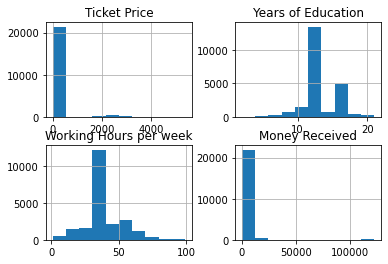

In [20]:
Train[['Ticket Price', 'Years of Education', 'Working Hours per week', 'Money Received']].hist()
plt.show()

array([[<AxesSubplot:title={'center':'Education Level'}>]], dtype=object)

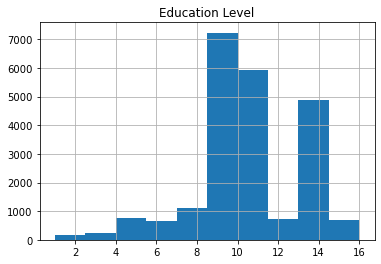

In [21]:
Train[['Education Level']].astype(int).hist()

### Boxplots

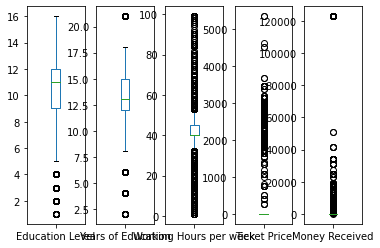

In [22]:
Train[['Education Level', 'Years of Education', 'Working Hours per week', 'Ticket Price', 'Money Received']].plot(kind='box', subplots=True, sharex=False, sharey=False)
plt.show()

## Multivariate Analysis

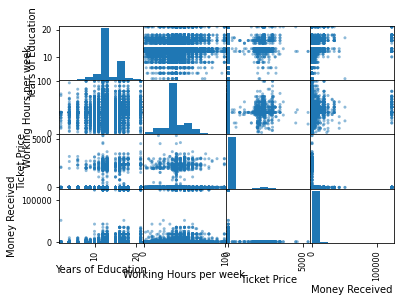

In [23]:
scatter_matrix(Train[['Education Level', 'Years of Education', 'Working Hours per week', 'Ticket Price', 'Money Received']])
plt.show()

## Outlier analysis

In [24]:
# Make boxplot, histogram graph of outliers and calculate number of outliers less/more than min/max limit
def show_outlier(fields, df):
    for field in fields:
        # Cut the window in 2 parts
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(6,4))
        # Add a graph in each part
        sns.boxplot(x = df[field], ax=ax_box)
        sns.histplot(x = df[field], ax=ax_hist)
        f.show()

In [25]:
# finds outliers of given field based on IQR method
def find_outliers(df, limit = 1.5):
    fields = []
    for field in df:
        if df[field].dtypes == 'object':
            continue
        IQR = df[field].quantile(0.75) - df[field].quantile(0.25)
        total = np.float(df.shape[0])
        upper_limit = df[field].quantile(0.75) + (int(IQR) * limit)
        lower_limit = df[field].quantile(0.25) - (int(IQR) * limit)
        uppler_limit_count = (df[field] > upper_limit).sum()
        lower_limit_count = (df[field] < lower_limit).sum()
        upper_limit_percent = int((uppler_limit_count / total) * 100)
        lower_limit_percent = int((lower_limit_count / total) * 100)
        if upper_limit_percent > 0 or lower_limit_percent > 0:
            fields.append(field)
            print(field)
            print('Percent of outliers less/more than min/max limit:')
            print(str(int((lower_limit_count / total) * 100)) + '%', str(int((uppler_limit_count / total) * 100))+ '%')
    return fields

In [26]:
non_cat = ['Years of Education', 'Working Hours per week', 'Age']

In [27]:
outliers = find_outliers(Train[non_cat])

Years of Education
Percent of outliers less/more than min/max limit:
1% 1%
Working Hours per week
Percent of outliers less/more than min/max limit:
16% 10%


<ipython-input-24-fbf5695621b3>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
<ipython-input-24-fbf5695621b3>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


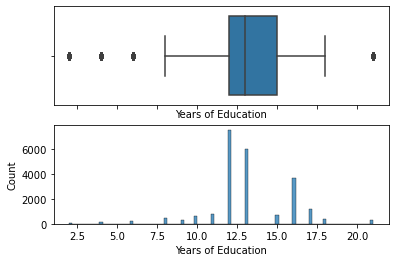

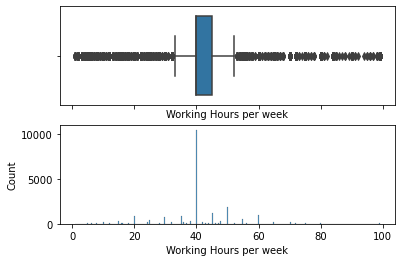

In [28]:
# Draw boxplot and histogram for fields with outliers
show_outlier(outliers, Train)

## Modify

### Transform and create variables

In this section a several transformations in the categorical data need to be done. 
It will be assing a numerical value (int) to each possible category for each variable.

## Fill Missing data 

In [29]:
Train.isna().sum()

Base Area                         395
Education Level                     0
Years of Education                  0
Working Hours per week              0
Money Received                      0
Ticket Price                        0
Income                              0
Sex                                 0
Age                                 0
Europe                              0
Africa                              0
Asia                                0
America                             0
Oceania                             0
Married                             0
Single                              0
Divorced                            0
Separated                           0
Widow                               0
Married - Spouse Missing            0
Married - Spouse in the Army        0
Wife                                0
Other Family                        0
Children                            0
Alone                               0
Husband                             0
Other relati

### Correlation Analysis

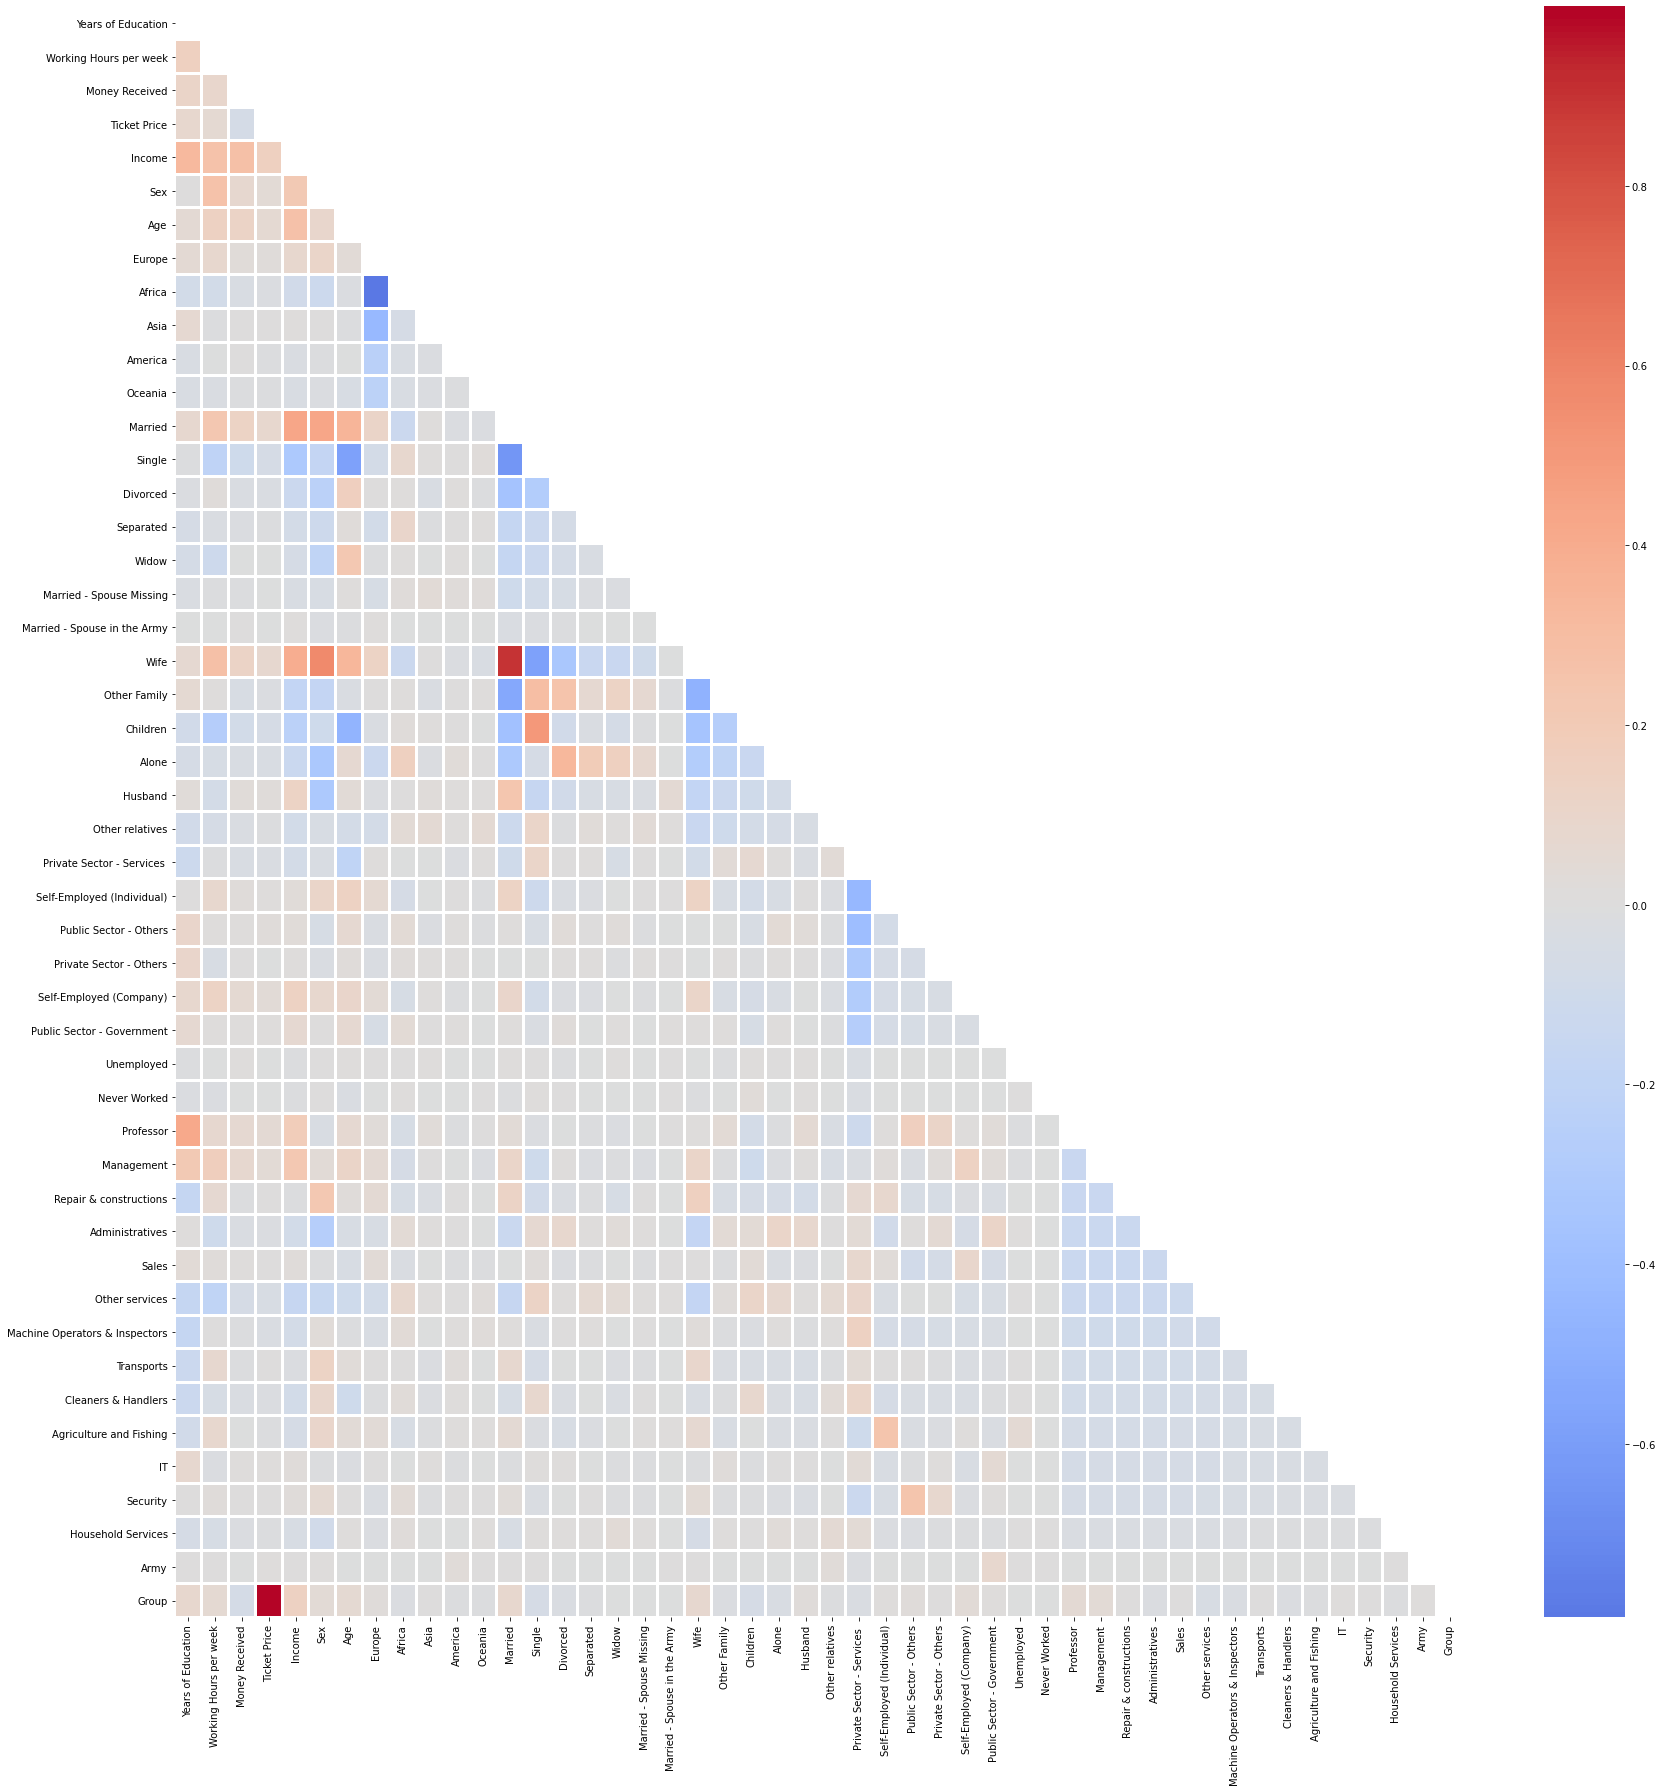

In [30]:
plt.rcParams['figure.figsize'] = (25,25)

corr_matrix=Train.corr(method = 'spearman')
mask=np.zeros_like(corr_matrix, dtype=np.bool)

mask[np.triu_indices_from(mask)]=True
sns.heatmap(data=corr_matrix, mask=mask, center=0, annot=False, linewidths=2, cmap='coolwarm')
plt.tight_layout()

### Train Validation Partition

In [28]:
TrainVP = Train.copy()

In [29]:
TrainVP = TrainVP.drop(columns=['Income'])
TrainVP

,Base Area,Education Level,Years of Education,Working Hours per week,Money Received,Ticket Price,Sex,Age,Europe,Africa,...,Other services,Machine Operators & Inspectors,Transports,Cleaners & Handlers,Agriculture and Fishing,IT,Security,Household Services,Army,Group
0,Northbury,11,13,40,0,2273,1,45,1,0,...,0,0,0,0,0,0,0,0,0,3
1,Northbury,9,12,40,0,0,1,42,1,0,...,0,0,0,0,0,0,0,0,0,1
2,Northbury,9,12,46,0,2321,1,39,1,0,...,0,0,0,0,0,0,0,0,0,3
3,Northbury,7,11,37,5395,0,1,63,1,0,...,0,0,0,0,0,0,1,0,0,1
4,Northbury,16,21,45,0,0,1,33,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22395,Northbury,9,12,40,0,0,0,25,1,0,...,0,0,0,1,0,0,0,0,0,1
22396,Northbury,9,12,35,0,0,1,23,1,0,...,1,0,0,0,0,0,0,0,0,1
22397,Northbury,14,17,40,2674,0,0,26,1,0,...,0,0,0,0,0,0,0,0,0,1
22398,Northbury,13,16,90,0,0,1,37,1,0,...,0,0,0,0,0,0,0,0,0,1


In [30]:
Test.columns

Index(['Base Area', 'Education Level', 'Years of Education',
       'Working Hours per week', 'Money Received', 'Ticket Price', 'Sex',
       'Age', 'Europe', 'Africa', 'Asia', 'America', 'Oceania', 'Married',
       'Single', 'Divorced', 'Separated', 'Widow', 'Married - Spouse Missing',
       'Married - Spouse in the Army', 'Wife', 'Other Family', 'Children',
       'Alone', 'Husband', 'Other relatives', 'Private Sector - Services ',
       'Self-Employed (Individual)', 'Public Sector - Others',
       'Private Sector - Others', 'Self-Employed (Company)',
       'Public Sector - Government', 'Unemployed', 'Repair & constructions',
       'Professor', 'Management', 'Administratives', 'Sales', 'Other services',
       'Machine Operators & Inspectors', 'Transports', 'Cleaners & Handlers',
       'IT', 'Agriculture and Fishing', 'Security', 'Household Services',
       'Army', 'Group'],
      dtype='object')

In [31]:
variables= ['Sex','Married','Single', 'Divorced', 'Separated', 'Widow',
            'Married - Spouse Missing', 'Married - Spouse in the Army', 'Wife',
            'Other Family', 'Children', 'Alone', 'Husband', 'Other relatives',
            'Private Sector - Services ', 'Self-Employed (Individual)',
            'Public Sector - Others', 'Private Sector - Others',
            'Self-Employed (Company)', 'Public Sector - Government', 'Unemployed',
            'Professor', 'Management', 'Repair & constructions',
            'Administratives', 'Sales', 'Other services',
            'Machine Operators & Inspectors', 'Transports', 'Cleaners & Handlers',
            'Agriculture and Fishing', 'IT', 'Security', 'Household Services',
            'Army', 'Europe', 'Africa', 'Asia', 'America', 'Oceania','Money Received', 
            'Years of Education', 'Ticket Price', 'Age', 'Working Hours per week', 'Group']

X = Train[variables]

y = Train['Income']

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=15, shuffle=True, stratify=y)

In [33]:
X_train

,Sex,Married,Single,Divorced,Separated,Widow,Married - Spouse Missing,Married - Spouse in the Army,Wife,Other Family,...,Africa,Asia,America,Oceania,Money Received,Years of Education,Ticket Price,Age,Working Hours per week,Group
5875,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,12,0,21,45,1
2413,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,9456,16,0,31,40,1
21423,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,12,0,33,40,1
9352,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,13,0,61,40,1
3613,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,16,0,57,50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21839,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,13,0,23,28,1
18990,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,12,0,28,40,1
4547,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,12,0,21,36,1
14753,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,12,0,20,30,1


### Data Standardization

In [34]:
scaler = StandardScaler().fit(X_train)  # z-score
#scaler = RobustScaler().fit(X_train) # robust standardization

scaler_X_train = scaler.transform(X_train)
scaler_X_train = pd.DataFrame(scaler_X_train, columns=variables)

scaler_X_val = scaler.transform(X_val)
scaler_X_val = pd.DataFrame(scaler_X_val, columns=variables)

Test = Test[variables]
scaler_X_test = scaler.transform(Test)
scaler_X_test = pd.DataFrame(scaler_X_test, columns=variables)

### Feature Selection

#### Lasso Regression

In [35]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [36]:
reg = LassoCV()
reg.fit(scaler_X_train, y_train)
coef = pd.Series(reg.coef_, index=scaler_X_train.columns)
coef.sort_values()

Group                            -0.070512
Agriculture and Fishing          -0.017815
Machine Operators & Inspectors   -0.008751
Cleaners & Handlers              -0.008591
Other Family                     -0.008339
Transports                       -0.006353
Single                           -0.005323
Asia                             -0.005218
Self-Employed (Individual)       -0.005050
Divorced                         -0.003559
Alone                            -0.003348
Private Sector - Others          -0.003054
Oceania                          -0.002432
Unemployed                       -0.002337
Other services                   -0.002211
Army                             -0.002065
Repair & constructions           -0.001708
America                          -0.001470
Separated                         0.000000
Public Sector - Others           -0.000000
Africa                            0.000000
Children                         -0.000000
Other relatives                   0.001717
Household S

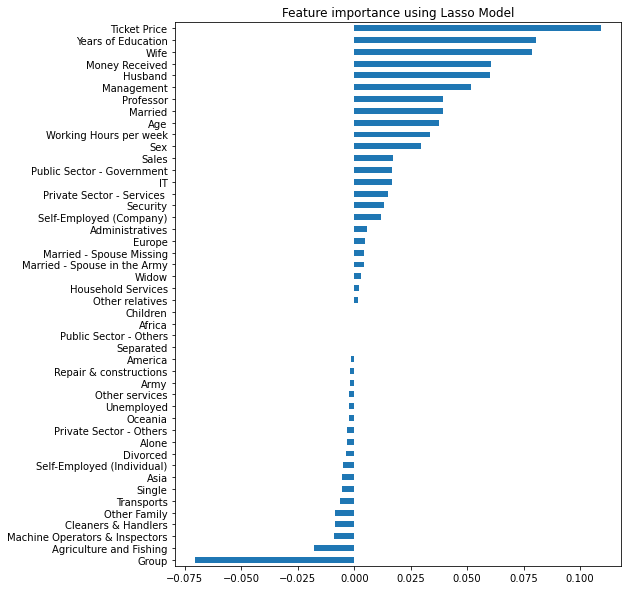

In [37]:
plot_importance(coef, 'Lasso')

#### Ridge Regression

In [38]:
ridge = RidgeCV()
ridge.fit(X=scaler_X_train, y=y_train)
coef_ridge = pd.Series(ridge.coef_, index=scaler_X_train.columns)
print(coef_ridge.sort_values())

Group                            -0.076804
Other Family                     -0.037465
Children                         -0.023661
Alone                            -0.023655
Agriculture and Fishing          -0.021079
Single                           -0.016681
Machine Operators & Inspectors   -0.013175
Cleaners & Handlers              -0.012283
Divorced                         -0.011860
Transports                       -0.010278
Other relatives                  -0.009270
Repair & constructions           -0.007762
Other services                   -0.007579
Asia                             -0.005675
Separated                        -0.004143
Oceania                          -0.002733
Army                             -0.002482
Unemployed                       -0.002123
America                          -0.001758
Widow                            -0.000972
Africa                           -0.000356
Self-Employed (Individual)       -0.000347
Private Sector - Others           0.000186
Administrat

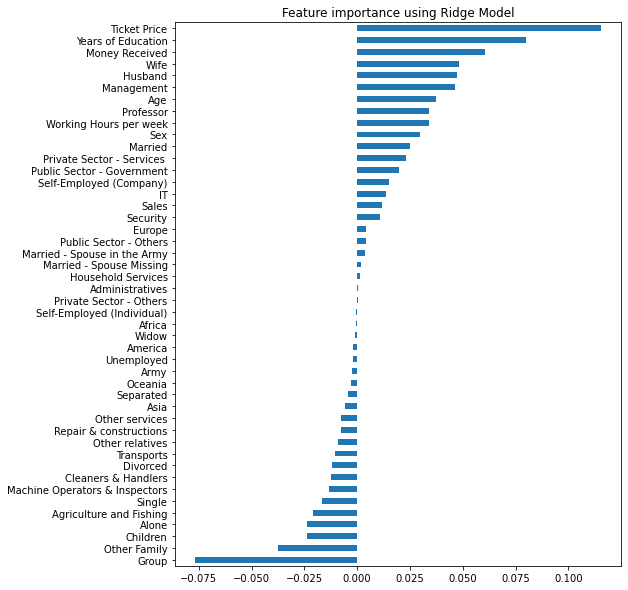

In [39]:
plot_importance(coef_ridge,'Ridge')

#### Recursive Feature Elimination

In [40]:
# nro of features
nof_list=np.arange(1,10)            
high_score=0
# Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):

    X_train_rfe, X_rfe_val, y_train_rfe, y_rfe_val = train_test_split(scaler_X_train, y_train, test_size = 0.25, 
                                                                      random_state = 15)
    
    model_rfe = LogisticRegression()
    rfe = RFE(model_rfe,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_rfe,y_train_rfe)
    X_rfe_val = rfe.transform(X_rfe_val)
    
    model_rfe.fit(X_train_rfe,y_train_rfe)
    
    score = model_rfe.score(X_rfe_val,y_rfe_val)
    score_list.append(score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=4 as keyword args. From version 0.25 passing these as positional 

Optimum number of features: 8
Score with 8 features: 0.836190


#### Visualize the weight of the dependent variable in categorical data

Income       0     1    All
Married                    
0        11358   823  12181
1         5731  4488  10219
All      17089  5311  22400


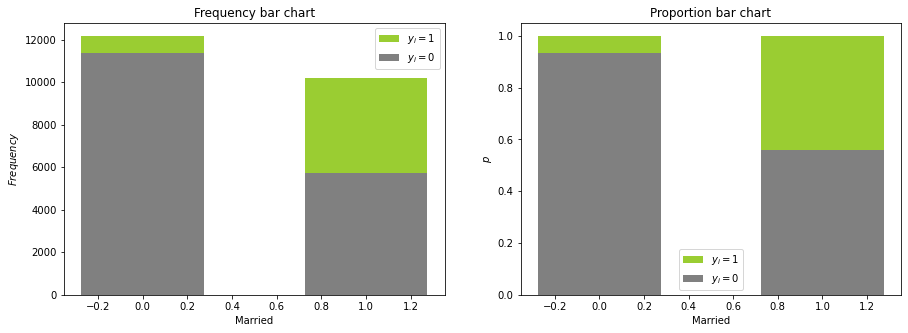

In [41]:
def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    print(cont_tab)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")

    plt.show()
    
bar_charts_categorical(Train, 'Married', 'Income')

Income      0     1    All
Group                     
1       16572  4771  21343
3         517   540   1057
All     17089  5311  22400


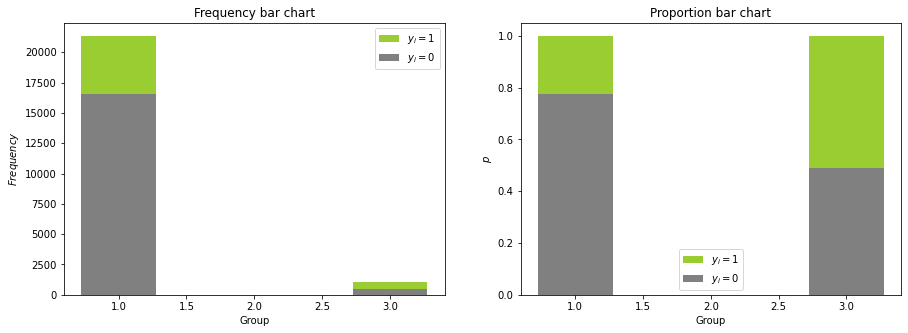

In [42]:
def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    print(cont_tab)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")

    plt.show()
    
bar_charts_categorical(Train, 'Group', 'Income')

#### Dimensionality Reduction

In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4, svd_solver='arpack')
pca.fit(scaler_X_train, y_train)
# Obtain X embedded
X_embedded_train = pd.DataFrame(pca.transform(scaler_X_train))
X_embedded_val = pd.DataFrame(pca.transform(scaler_X_val))
test_embedded = pd.DataFrame(pca.transform(scaler_X_test))

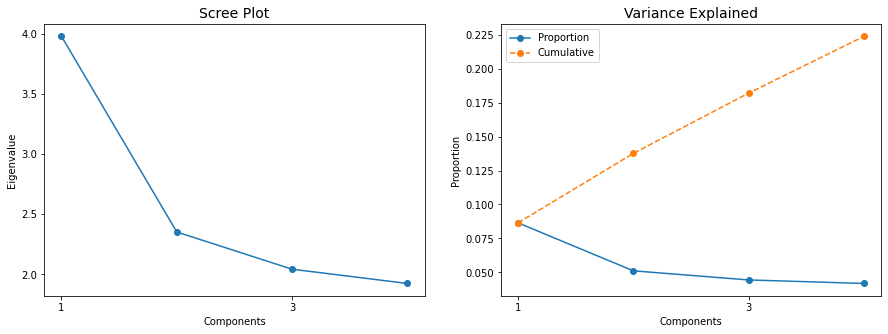

In [44]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
 
# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")
 
# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))
 
plt.show()

## Model

### Model Exploration

#### K Nearest Neighbors

In [45]:
k = 10
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=15)

In [64]:
#{'algorithm': 'auto',
# 'metric': 'cosine',
# 'n_neighbors': 28,
# 'weights': 'uniform'}

In [65]:
#knn_clf = KNeighborsClassifier()

#knn_parameters = {'n_neighbors' : np.arange(1,31,1),
#                  'metric' : ['euclidean', 'cosine', 'manhattan', 'minkowski'],
#                  'weights' : ['uniform', 'distance'],
#                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

#knn_grid = GridSearchCV(estimator=knn_clf, param_grid=knn_parameters, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)

#knn_grid.fit(scaler_X_train, y_train)

#knn_grid.best_params_

In [66]:
KNN = KNeighborsClassifier(n_neighbors=28, algorithm='auto', metric='cosine', weights='uniform').fit(X = scaler_X_train, y = y_train)
print(KNN.score(scaler_X_train, y_train))
print(KNN.score(scaler_X_val, y_val))

0.8445833333333334
0.8407142857142857


#### K Nearest Centroid

In [67]:
#{'metric': 'euclidean'}

In [68]:
#knc_clf = NearestCentroid()

#knc_parameters = {'metric' : ['euclidean', 'cosine', 'manhattan']}

#knc_grid = GridSearchCV(estimator=knc_clf, param_grid=knc_parameters, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)

#knc_grid.fit(scaler_X_train, y_train)

#knc_grid.best_params_

In [69]:
KNC = NearestCentroid(metric='euclidean').fit(X = scaler_X_train, y = y_train)
print(KNC.score(scaler_X_train, y_train))
print(KNC.score(scaler_X_val, y_val))

0.7382738095238095
0.7530357142857143


#### Random Forest

In [70]:
#{'criterion': 'gini',
# 'max_features': 'sqrt',
# 'n_estimators': 100,
# 'warm_start': True}

In [71]:
#rf_clf = RandomForestClassifier(class_weight='balanced', random_state=15)

#rf_parameters = {"n_estimators": np.arange(100, 400, 100),
#                  "max_features": ['sqrt', 'log2', 'auto', None],
#                  "criterion": ['gini', 'entropy'],
#                  "warm_start" : [True, False]}

#rf_grid = GridSearchCV(estimator=rf_clf, param_grid=rf_parameters, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)

#rf_grid.fit(scaler_X_train, y_train)
#rf_grid.best_params_

In [72]:
from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier(criterion='gini',max_features='sqrt',n_estimators=100,warm_start=True).fit(X=scaler_X_train, y=y_train)
print(RF.score(scaler_X_train,y_train))
print(RF.score(scaler_X_val, y_val))

0.9800595238095238
0.8489285714285715


In [73]:
from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier(criterion='gini',max_features='sqrt',n_estimators=100,warm_start=False,verbose=3).fit(X=scaler_X_train, y=y_train)
print(RF.score(scaler_X_train,y_train))
print(RF.score(scaler_X_val, y_val))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


0.9800595238095238
0.8489285714285715


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


#### Decision Tree

In [74]:
#max_leaf_nodes=23
#min_samples_split=2

In [75]:
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.model_selection import GridSearchCV
#params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
#grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
#grid_search_cv.fit(scaler_X_train, y_train)
#grid_search_cv.best_params_

In [76]:
from sklearn.tree import DecisionTreeClassifier
DT= DecisionTreeClassifier(max_leaf_nodes=23, min_samples_split=2).fit(scaler_X_train,y_train)
print(DT.score(scaler_X_train,y_train))
print(DT.score(scaler_X_val, y_val))

0.8545833333333334
0.8544642857142857


In [77]:
DT= DecisionTreeClassifier(min_samples_split=2, max_leaf_nodes=50
                           ).fit(scaler_X_train,y_train)
print(DT.score(scaler_X_train,y_train))
print(DT.score(scaler_X_val, y_val))

0.8644642857142857
0.8607142857142858


#### Passive Agressive

In [78]:
#{'class_weight': None,
# 'early_stopping': True,
# 'max_iter': 100,
# 'warm_start': True}

In [79]:
#pa_clf = PassiveAggressiveClassifier(random_state=15)

#pa_parameters = {"warm_start" : [True, False],
#                  "early_stopping" : [True, False],
#                  "max_iter" : (100, 500, 1000),
#                  "class_weight" : ['balanced', None]}

#pa_grid = GridSearchCV(estimator=pa_clf, param_grid=pa_parameters, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)

#pa_grid.fit(scaler_X_train, y_train)
#pa_grid.best_params_

In [80]:
PA = PassiveAggressiveClassifier(class_weight=None, early_stopping=True, max_iter=100, warm_start=True
                                      ).fit(scaler_X_train, y_train)
print(PA.score(scaler_X_train, y_train))
print(PA.score(scaler_X_val, y_val))

0.7832142857142858
0.7825


#### Logistic Regression

In [81]:
#{'max_iter': 100, 'solver': 'newton-cg', 'warm_start': True}

In [82]:
#log_clf = LogisticRegression()

#log_parameters = {'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
#                   'warm_start' : [True, False],
#                   'max_iter' : (100, 200, 300)}

#log_grid = GridSearchCV(estimator=log_clf, param_grid=log_parameters, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)
#log_grid.fit(scaler_X_train, y_train)
#log_grid.best_params_

In [83]:
LOG = LogisticRegression(max_iter=100, solver='newton-cg', warm_start=True).fit(scaler_X_train, y_train) 
print(LOG.score(scaler_X_train, y_train))
print(LOG.score(scaler_X_val, y_val))

0.8514880952380952
0.8516071428571429


#### Multi-Layer Perceptron

In [84]:
#{'activation': 'relu',
# 'alpha': 0.05,
# 'hidden_layer_sizes': (50, 100, 50),
# 'learning_rate': 'constant',
# 'solver': 'adam'}

In [85]:
#mlp = MLPClassifier(random_state=15)

#mlp_parameters = {
#    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
#    'activation': ['tanh', 'relu'],
#    'solver': ['sgd', 'adam'],
#    'alpha': [0.0001, 0.05],
#    'learning_rate': ['constant','adaptive'],
#}
#mlp_grid = GridSearchCV(estimator=mlp, param_grid=mlp_parameters, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)
#mlp_grid.fit(scaler_X_train, y_train)
#mlp_grid.best_params_

In [86]:
MLP = MLPClassifier(activation= 'relu',alpha= 0.05, hidden_layer_sizes= (50, 100, 50), learning_rate= 'constant',solver='adam').fit(scaler_X_train,y_train)
print(MLP.score(scaler_X_train, y_train))
print(MLP.score(scaler_X_val, y_val))

0.9222023809523809
0.8339285714285715


#### Naive Bayes

In [87]:
#{'var_smoothing': 1.0}

In [88]:
#nb_classifier = GaussianNB()
#params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
#gs_NB = GridSearchCV(estimator=nb_classifier, 
#                 param_grid=params_NB, 
#                 cv=cv,   # use any cross validation technique 
#                 verbose=1, 
#                 scoring='accuracy') 
#gs_NB.fit(scaler_X_train, y_train)
#gs_NB.best_params_

In [89]:
NB = GaussianNB(var_smoothing= 1.0).fit(scaler_X_train, y_train)
print(NB.score(scaler_X_train, y_train))
print(NB.score(scaler_X_val, y_val))

0.7308333333333333
0.7501785714285715


#### Support Vector Machine (SVM)

In [90]:
#{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

In [91]:
#svm_clf = SVC()

#svm_parameters = {
#     'kernel' : ['poly', 'rbf', 'sigmoid'],
#     'gamma' : ['scale', 'auto'],
#     'C' : [50, 10, 1.0, 0.1, 0.01]
# }


#svm_grid = GridSearchCV(estimator= svm_clf, param_grid=svm_parameters, cv = cv, scoring='accuracy', verbose=1, n_jobs=-1)
#svm_grid.fit(scaler_X_train, y_train)
#print("Best Score: ", svm_grid.best_score_)
#print("Best MLP: ", svm_grid.best_estimator_)
#svm_grid.best_params_

In [92]:
SVM = SVC(C= 10, gamma='auto',kernel='rbf').fit(scaler_X_train, y_train)
print(SVM.score(scaler_X_train, y_train))
print(SVM.score(scaler_X_val, y_val))

0.8772619047619048
0.8482142857142857


## Ensemble

#### Bagging Classifier

In [93]:
#{'base_estimator': None,
# 'bootstrap': False,
# 'bootstrap_features': True,
# 'n_estimators': 1000}

In [94]:
#bbc_clf = BaggingClassifier()

#bbc_parameters = {'base_estimator' : [None, KNN, KNC ,DT, RF, PA, LOG, MLP, NB, SVM],
#                   'n_estimators' : [10, 100, 1000],
#                   'bootstrap' : [True, False],
#                   'bootstrap_features' : [True, False]
#}



#bbc_grid = GridSearchCV(estimator=bbc_clf, param_grid=bbc_parameters, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)
#bbc_grid.fit(scaler_X_train, y_train)
#bbc_grid.best_params_

In [95]:
bagging = BaggingClassifier(base_estimator=DT, n_estimators=10, bootstrap=True, bootstrap_features=True, 
                               warm_start=True, random_state=15).fit(scaler_X_train, y_train)
print(bagging.score(scaler_X_train, y_train))
print(bagging.score(scaler_X_val, y_val))

0.8700595238095238
0.86375


In [96]:
GB = GradientBoostingClassifier(learning_rate=0.25, loss='deviance', n_estimators=100, criterion='friedman_mse', 
                           ).fit(scaler_X_train,y_train)
print(GB.score(scaler_X_train, y_train))
print(GB.score(scaler_X_val, y_val))

0.8805952380952381
0.8733928571428572


In [97]:
bagging_gb = BaggingClassifier(base_estimator=GB, n_estimators=10, bootstrap=True, bootstrap_features=True, 
                               warm_start=True, random_state=15).fit(scaler_X_train, y_train)
print(bagging.score(scaler_X_train, y_train))
print(bagging.score(scaler_X_val, y_val))

0.8700595238095238
0.86375


#### AdaBoost Classifier

In [98]:
#AdaBoost = AdaBoostClassifier()

#AdaBoost_parameters = {'base_estimator' : [None, KNN, KNC , RF, DT, PA, LOG, MLP, NB, SVM],
#                        'n_estimators' : np.arange(40, 105, 5),
#                        'learning_rate' : (0.01, 0.1, 1, 10),
#                        'algorithm' : ['SAMME', 'SAMME.R']}

#AdaBoost_grid = GridSearchCV(estimator=AdaBoost, param_grid=AdaBoost_parameters, cv=cv, 
#                              scoring='accuracy', verbose=1, n_jobs=-1)

#AdaBoost_grid.fit(scaler_X_train , y_train)
#AdaBoost_grid.best_params_

In [102]:
from sklearn.ensemble import AdaBoostClassifier
adaboost_gb = AdaBoostClassifier(base_estimator=GB, n_estimators=50, learning_rate=0.01, 
                              algorithm='SAMME', random_state=15).fit(scaler_X_train, y_train)
print(adaboost_gb.score(scaler_X_train, y_train))
print(adaboost_gb.score(scaler_X_val, y_val))

0.8832142857142857
0.8746428571428572


In [103]:
adaboost = AdaBoostClassifier(base_estimator=DT, algorithm='SAMME').fit(scaler_X_train, y_train)
print(adaboost.score(scaler_X_train, y_train))
print(adaboost.score(scaler_X_val, y_val))

0.8904166666666666
0.8676785714285714


In [104]:
adaboost = AdaBoostClassifier(base_estimator=bagging, algorithm='SAMME').fit(scaler_X_train, y_train)
print(adaboost.score(scaler_X_train, y_train))
print(adaboost.score(scaler_X_val, y_val))

0.9436309523809524
0.8491071428571428


#### Voting Classifier

In [105]:
VC=VotingClassifier(estimators=[('KNN',KNN),('KNC',KNC),('RF',RF),('DT',DT),('PA',PA),('LOG',LOG),('MLP',MLP),('NB',NB),('SVM',SVM)],
                   )

VC.fit(scaler_X_train,y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished
/jupyter/venv/lib64/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


VotingClassifier(estimators=[('KNN',
                              KNeighborsClassifier(metric='cosine',
                                                   n_neighbors=28)),
                             ('KNC', NearestCentroid()),
                             ('RF',
                              RandomForestClassifier(max_features='sqrt',
                                                     verbose=3)),
                             ('DT', DecisionTreeClassifier(max_leaf_nodes=50)),
                             ('PA',
                              PassiveAggressiveClassifier(early_stopping=True,
                                                          max_iter=100,
                                                          warm_start=True)),
                             ('LOG',
                              LogisticRegression(solver='newton-cg',
                                                 warm_start=True)),
                             ('MLP',
                              MLPClass

In [106]:
from sklearn.metrics import accuracy_score
labels_train_vc = VC.predict(scaler_X_train)
accuracy_score(y_train, labels_train_vc)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


0.8861309523809524

In [107]:
labels_val_vc = VC.predict(scaler_X_val)
accuracy_score(y_val, labels_val_vc)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


0.8539285714285715

In [108]:
VC=VotingClassifier(estimators=[('DT',DT),('GB',GB)] )

VC.fit(scaler_X_train,y_train)


VotingClassifier(estimators=[('DT', DecisionTreeClassifier(max_leaf_nodes=50)),
                             ('GB',
                              GradientBoostingClassifier(learning_rate=0.25))])

In [109]:
from sklearn.metrics import accuracy_score
labels_train_vc = VC.predict(scaler_X_train)
accuracy_score(y_train, labels_train_vc)

0.8719642857142857

In [110]:
labels_val_vc = VC.predict(scaler_X_val)
accuracy_score(y_val, labels_val_vc)

0.8635714285714285

#### Gradient Boost Classifier

In [111]:
#{'learning_rate': 0.1,
# 'loss': 'exponential',
# 'max_depth': 5,
# 'max_features': 'log2',
# 'n_estimators': 100,
# 'warm_start': True}

In [112]:
#GBC= GradientBoostingClassifier()

#GBC_parameters={'loss' : ['deviance', 'exponential'],
#                  'learning_rate' : (0.01, 0.1, 1),
#                  'n_estimators' : np.arange(100, 400, 100),
#                  'max_depth' : (5, 10, 15, 20, 30),
#                  'max_features' : ['auto', 'log2', None],
#                  'warm_start' : [True, False]}

#GBD_grid=GridSearchCV(estimator=GBC,param_grid=GBC_parameters,cv=cv,scoring='accuracy',verbose=1,n_jobs=-1)
#GBD_grid.fit(scaler_X_train,y_train)
#GBD_grid.best_params_

In [47]:
GB = GradientBoostingClassifier(learning_rate=0.1, loss='exponential',max_depth=5,max_features='log2', n_estimators=100, 
                                warm_start=True).fit(scaler_X_train,y_train)
print(GB.score(scaler_X_train, y_train))
print(GB.score(scaler_X_val, y_val))

0.8702380952380953
0.8657142857142858


# Stacking Classifier

In [113]:
#from sklearn.metrics import accuracy_score

In [114]:
#SC = StackingClassifier(estimators=[('KNN',KNN),('KNC',KNC),('RF',RF),('DT',DT),('PA',PA),('LOG',LOG),('MLP',MLP),('NB',NB),('SVM',SVM),('GB',GB)], final_estimator=GB).fit(scaler_X_train, y_train)

In [115]:
#labels_train_sc = SC.predict(scaler_X_train)
#accuracy_score(y_train, labels_train_sc)

In [116]:
#labels_val_sc = SC.predict(scaler_X_val)
#accuracy_score(y_val, labels_val_sc)

In [117]:
#SC = StackingClassifier(estimators=[('KNN',KNN),('KNC',KNC),('RF',RF),('DT',DT),('PA',PA),('LOG',LOG),('MLP',MLP),('NB',NB),('SVM',SVM)], final_estimator=MLP).fit(scaler_X_train, y_train)

In [118]:
#labels_train_sc = SC.predict(scaler_X_train)
#accuracy_score(y_train, labels_train_sc)

In [119]:
#labels_val_sc = SC.predict(scaler_X_val)
#accuracy_score(y_val, labels_val_sc)

In [120]:
#SC = StackingClassifier(estimators=[('KNN',KNN),('KNC',KNC),('RF',RF),('DT',DT),('PA',PA),('LOG',LOG),('MLP',MLP),('NB',NB),('SVM',SVM)], final_estimator=KNN).fit(scaler_X_train, y_train)

In [121]:
#labels_train_sc = SC.predict(scaler_X_train)
#accuracy_score(y_train, labels_train_sc)

In [122]:
#labels_val_sc = SC.predict(scaler_X_val)
#accuracy_score(y_val, labels_val_sc)

In [123]:
#SC = StackingClassifier(estimators=[('KNN',KNN),('KNC',KNC),('RF',RF),('DT',DT),('PA',PA),('LOG',LOG),('MLP',MLP),('NB',NB),('SVM',SVM)], final_estimator=KNC).fit(scaler_X_train, y_train)

In [124]:
#labels_train_sc = SC.predict(scaler_X_train)
#accuracy_score(y_train, labels_train_sc)

In [125]:
#labels_val_sc = SC.predict(scaler_X_val)
#accuracy_score(y_val, labels_val_sc)

In [126]:
#SC = StackingClassifier(estimators=[('KNN',KNN),('KNC',KNC),('RF',RF),('DT',DT),('PA',PA),('LOG',LOG),('MLP',MLP),('NB',NB),('SVM',SVM)], final_estimator=RF).fit(scaler_X_train, y_train)

In [127]:
#labels_train_sc = SC.predict(scaler_X_train)
#accuracy_score(y_train, labels_train_sc)

In [128]:
#labels_val_sc = SC.predict(scaler_X_val)
#accuracy_score(y_val, labels_val_sc)

In [129]:
#SC = StackingClassifier(estimators=[('KNN',KNN),('KNC',KNC),('RF',RF),('DT',DT),('PA',PA),('LOG',LOG),('MLP',MLP),('NB',NB),('SVM',SVM)], final_estimator=PA).fit(scaler_X_train, y_train)

In [130]:
#labels_train_sc = SC.predict(scaler_X_train)
#accuracy_score(y_train, labels_train_sc)

In [131]:
#labels_val_sc = SC.predict(scaler_X_val)
#accuracy_score(y_val, labels_val_sc)

In [132]:
#SC = StackingClassifier(estimators=[('KNN',KNN),('KNC',KNC),('RF',RF),('DT',DT),('PA',PA),('LOG',LOG),('MLP',MLP),('NB',NB),('SVM',SVM)], final_estimator=LOG).fit(scaler_X_train, y_train)

In [133]:
#labels_train_sc = SC.predict(scaler_X_train)
#accuracy_score(y_train, labels_train_sc)

In [134]:
#labels_val_sc = SC.predict(scaler_X_val)
#accuracy_score(y_val, labels_val_sc)

In [135]:
#SC = StackingClassifier(estimators=[('KNN',KNN),('KNC',KNC),('RF',RF),('DT',DT),('PA',PA),('LOG',LOG),('MLP',MLP),('NB',NB),('SVM',SVM)], final_estimator=NB).fit(scaler_X_train, y_train)

In [136]:
#labels_train_sc = SC.predict(scaler_X_train)
#accuracy_score(y_train, labels_train_sc)

In [137]:
#labels_val_sc = SC.predict(scaler_X_val)
#accuracy_score(y_val, labels_val_sc)

In [138]:
#SC = StackingClassifier(estimators=[('KNN',KNN),('KNC',KNC),('RF',RF),('DT',DT),('PA',PA),('LOG',LOG),('MLP',MLP),('NB',NB),('SVM',SVM)], final_estimator=SVM).fit(scaler_X_train, y_train)

In [139]:
#labels_train_sc = SC.predict(scaler_X_train)
#accuracy_score(y_train, labels_train_sc)

In [140]:
#labels_val_sc = SC.predict(scaler_X_val)
#accuracy_score(y_val, labels_val_sc)

### Neural Networks

#### Neural Network 15 hidden units

In [142]:
MLP1 = MLPClassifier(activation='relu', alpha=0.025, batch_size='auto', beta_1=0.9, 
                     beta_2=0.999, early_stopping=False, epsilon=1e-08,        
                     hidden_layer_sizes=(15,), learning_rate='constant',   
                     learning_rate_init=0.025007500000000002, max_fun=15000, 
                     max_iter=800, momentum=0.9, n_iter_no_change=10,      
                     nesterovs_momentum=True, power_t=0.5, random_state=15,   
                     shuffle=True, solver='adam', tol=0.000505,         
                     validation_fraction=0.1, verbose=False, warm_start=True).fit(scaler_X_train, y_train)

In [143]:
labels_train_mlp1 = MLP1.predict(scaler_X_train)
labels_val_mlp1 = MLP1.predict(scaler_X_val)
print(accuracy_score(y_train, labels_train_mlp1))
print(accuracy_score(y_val, labels_val_mlp1))

0.8616071428571429
0.8560714285714286


#### Neural Network 10 hidden units

In [144]:
MLP2 = MLPClassifier(activation='relu', alpha=0.032, batch_size='auto', beta_1=0.9,    
                      beta_2=0.999, early_stopping=False, epsilon=1e-08,    
                      hidden_layer_sizes=(10,), learning_rate='constant', 
                      learning_rate_init=0.025007500000000002, max_fun=15000,   
                      max_iter=800, momentum=0.9, n_iter_no_change=10,           
                      nesterovs_momentum=True, power_t=0.5, random_state=15,  
                      shuffle=True, solver='adam', tol=0.000505,         
                      validation_fraction=0.1, verbose=False, warm_start=True).fit(scaler_X_train, y_train)

In [145]:
labels_train_mlp2 = MLP2.predict(scaler_X_train)
labels_val_mlp2 = MLP2.predict(scaler_X_val)
print(accuracy_score(y_train, labels_train_mlp1))
print(accuracy_score(y_val, labels_val_mlp2))

0.8616071428571429
0.8548214285714286


#### Neural Network 2 hidden layers

In [146]:
MLP3 = MLPClassifier(hidden_layer_sizes = (10,34), random_state = 15, warm_start = True, early_stopping=False,          
                     max_iter = 5000, activation ='relu', learning_rate = 'constant',
                     tol = 1e-05, solver = 'adam').fit(scaler_X_train, y_train)

In [147]:
labels_train_mlp3 = MLP3.predict(scaler_X_train)
labels_val_mlp3 = MLP3.predict(scaler_X_val)
print(accuracy_score(y_train, labels_train_mlp3))
print(accuracy_score(y_val, labels_val_mlp3))

0.871904761904762
0.8494642857142857


## Final Model

In [148]:
# Use the model to make predictions
predicted_income = adaboost_gb.predict(scaler_X_test)
# We will look at the predicted prices to ensure we have something sensible.
print(len(predicted_income))

10100


In [149]:
my_submission = pd.DataFrame()
my_submission['CITIZEN_ID'] = test_citizen_id
my_submission['Income'] = predicted_income
version=1
path = r'./submission' + str(version) + '.csv'
# you could use any filename. We choose submission here
my_submission.to_csv(path, index=False)

In [150]:
my_submission.Income.value_counts()

0    8002
1    2098
Name: Income, dtype: int64